In [1]:
import tensorflow as tf
import kagglehub
from datasets import load_dataset
from PIL import Image
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

2025-06-06 14:00:31.237251: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749218431.430100      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749218431.484310      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dataset = load_dataset("naver-clova-ix/cord-v2", split="train")
# gt = dataset[0]['ground_truth'] 
# print(gt)

README.md:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

(…)-00000-of-00004-b4aaeceff1d90ecb.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

(…)-00001-of-00004-7dbbe248962764c5.parquet:   0%|          | 0.00/441M [00:00<?, ?B/s]

(…)-00002-of-00004-688fe1305a55e5cc.parquet:   0%|          | 0.00/444M [00:00<?, ?B/s]

(…)-00003-of-00004-2d0cd200555ed7fd.parquet:   0%|          | 0.00/456M [00:00<?, ?B/s]

(…)-00000-of-00001-cc3c5779fe22e8ca.parquet:   0%|          | 0.00/242M [00:00<?, ?B/s]

(…)-00000-of-00001-9c204eb3f4e11791.parquet:   0%|          | 0.00/234M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/800 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

In [3]:
image_path = dataset[5]['image']  # Sudah dalam bentuk PIL.Image
# image = image.convert("RGB")  # Pastikan formatnya RGB

In [4]:
# Preprocessing gambar
image = np.array(image_path)
image_resized = cv2.resize(image, (640, 640))  # Resize sesuai dengan input model
image_array = np.array(image_resized) / 255.0  # Normalisasi
image_array = np.expand_dims(image_array, axis=0)  # Tambahkan batch dimension

In [5]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

model = load_model('/kaggle/input/bbox_model_v1/keras/default/1/bbox_model.h5', 
                   custom_objects={'mse': MeanSquaredError()})

I0000 00:00:1749218472.237235      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749218472.237968      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [6]:
# Lakukan prediksi
predictions = model.predict(image_array)

I0000 00:00:1749218476.998034     114 service.cc:148] XLA service 0x7c971c0038e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749218476.998633     114 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749218476.998658     114 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749218477.621208     114 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1749218479.150846     114 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749218479.321318     114 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


I0000 00:00:1749218484.138352     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [7]:
print("Classification output:", predictions[1][0].min(), predictions[1][0].max())
print("Bbox output:", predictions[0][0].min(), predictions[0][0].max())

Classification output: 0.0 7.8625e-07
Bbox output: -1.896074 1.6757197


In [8]:
label_map = {'item_name': 0, 'quantity': 1, 'price': 2}

In [9]:
def decode_predictions(predictions, label_map, score_threshold=0, down_ratio=4, image_width=640, image_height=640):
    bbox_output = predictions[0][0]  # Ambil batch pertama
    class_output = predictions[1][0]
    offset_output = predictions[2][0]
    
    output_size = class_output.shape[0]  # Asumsi square output
    detections = []
    
    for y in range(output_size):
        for x in range(output_size):
            class_probs = class_output[y, x, :]
            max_class = tf.argmax(class_probs)
            max_score = class_probs[max_class]
            
            if max_score > score_threshold:
                # Decode bounding box
                cx_offset, cy_offset, w, h = bbox_output[y, x, :]
                
                # Hitung center point dalam koordinat output
                cx = (x + cx_offset) * down_ratio
                cy = (y + cy_offset) * down_ratio
                
                # Konversi ke koordinat gambar asli
                x_min = int(cx - w * image_width / 2)
                y_min = int(cy - h * image_height / 2)
                x_max = int(cx + w * image_width / 2)
                y_max = int(cy + h * image_height / 2)
                
                # Normalisasi dan kliping koordinat ke dalam rentang gambar
                x_min = max(0, min(x_min, image_width - 1))
                y_min = max(0, min(y_min, image_height - 1))
                x_max = max(0, min(x_max, image_width - 1))
                y_max = max(0, min(y_max, image_height - 1))
                
                # Hanya tambahkan deteksi jika bounding box valid
                if x_max > x_min and y_max > y_min:  # Pastikan width dan height positif
                    detections.append({
                        "class": max_class,
                        "score": float(max_score),  # Konversi ke float native Python
                        "bbox": [x_min, y_min, x_max, y_max]
                    })
    
    return detections

# Decode predictions dengan dimensi gambar yang jelas
detections = decode_predictions(predictions, label_map, image_width=640, image_height=640)
print(detections)

[{'class': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'score': 1.829331477964935e-11, 'bbox': [0, 0, 17, 45]}, {'class': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'score': 7.979518602948751e-14, 'bbox': [6, 0, 18, 103]}, {'class': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'score': 6.158222803226421e-13, 'bbox': [13, 0, 34, 110]}, {'class': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'score': 9.817208894771778e-13, 'bbox': [12, 0, 44, 124]}, {'class': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'score': 1.2234549311151977e-12, 'bbox': [9, 0, 54, 128]}, {'class': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'score': 1.2847892237946579e-12, 'bbox': [11, 0, 60, 138]}, {'class': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'score': 1.2763991252828788e-12, 'bbox': [17, 0, 63, 137]}, {'class': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'score': 1.1524555181691154e-12, 'bbox': [17, 0, 70, 134]}, {'class': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'score': 1.0620745819270305e-12,

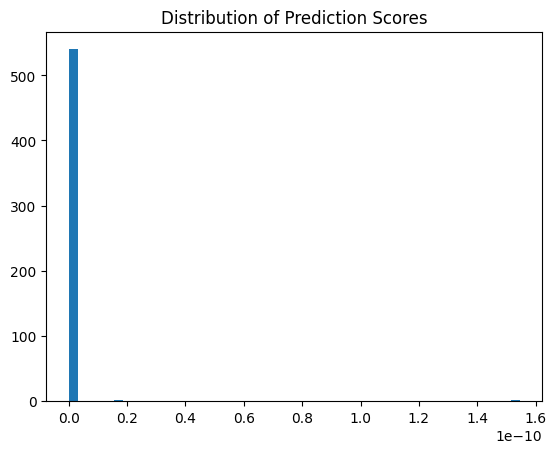

In [10]:
scores = [float(d['score']) for d in detections]
plt.hist(scores, bins=50)
plt.title('Distribution of Prediction Scores')
plt.show()

In [11]:
# Mengurutkan daftar 'detections' berdasarkan 'score' dari tertinggi ke terendah
sorted_detections = sorted(detections, key=lambda d: d['score'], reverse=True)

# Mengambil 3 elemen pertama dari daftar yang sudah diurutkan
top_3_detections = sorted_detections[:3]

# Menampilkan 3 deteksi terbaik
print("--- 3 Deteksi Terbaik (Skor Tertinggi) ---")
for i, detection in enumerate(top_3_detections):
    print(f"{i+1}. Skor: {detection['score']:.4f}, Kelas: {detection['class']}, BBox: {detection['bbox']}")

--- 3 Deteksi Terbaik (Skor Tertinggi) ---
1. Skor: 0.0000, Kelas: 2, BBox: [0, 0, 119, 31]
2. Skor: 0.0000, Kelas: 0, BBox: [0, 0, 17, 45]
3. Skor: 0.0000, Kelas: 0, BBox: [49, 0, 94, 116]


Plot berhasil disimpan sebagai plot_hasil_deteksi_tensorflow.png


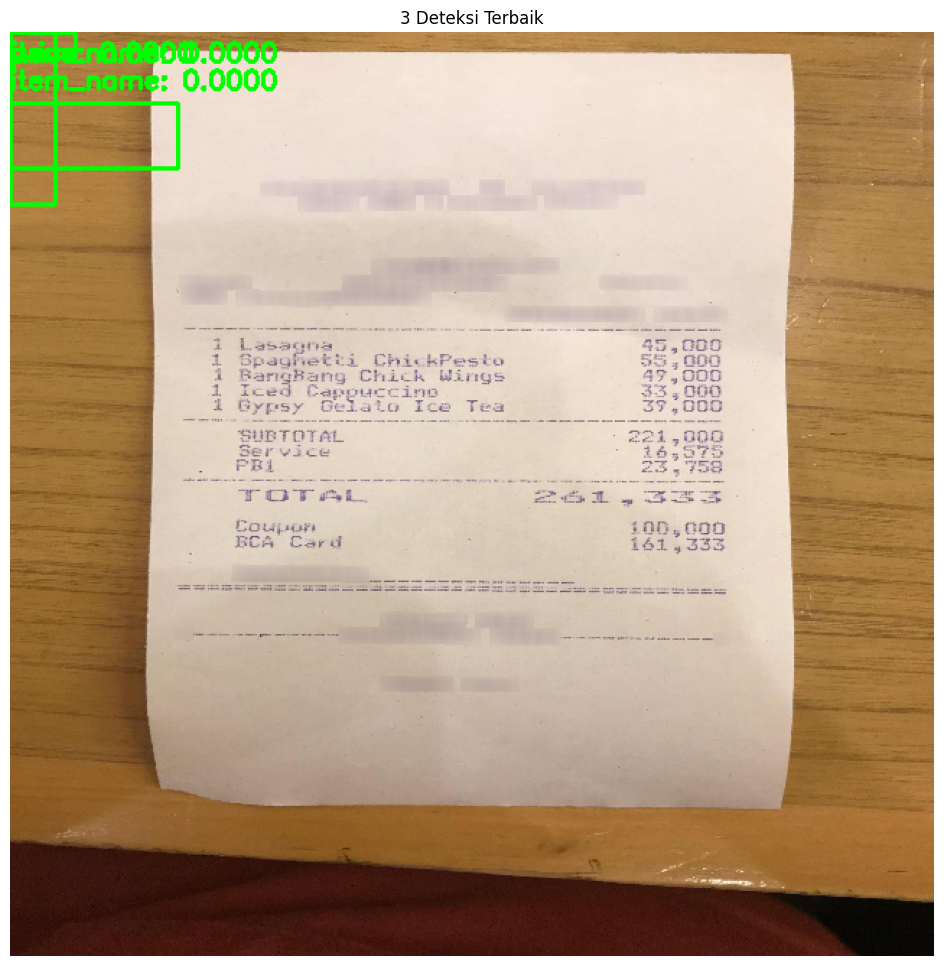

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf # Pastikan tensorflow di-import

# Konversi dan siapkan gambar
image_np = np.array(image)
if image_np.shape[0] != 640 or image_np.shape[1] != 640:
    image_resized = cv2.resize(image_np, (640, 640))
else:
    image_resized = image_np.copy()


# Loop untuk 3 deteksi terbaik
for pred in top_3_detections:
    # Ambil data mentah dari prediksi
    class_id_val = pred['class']
    score_val = pred['score']
    box_val = pred['bbox']

    # ===== PERBAIKAN PALING AMAN (ROBUST FIX) =====
    # Cek tipe data: jika Tensor, konversi dgn .numpy(). Jika bukan, gunakan langsung.
    class_id = class_id_val.numpy() if isinstance(class_id_val, tf.Tensor) else class_id_val
    score = score_val.numpy() if isinstance(score_val, tf.Tensor) else score_val
    box_raw = box_val.numpy() if isinstance(box_val, tf.Tensor) else box_val
    box = np.array(box_raw).astype(int)
    # ===============================================

    # Koordinat bbox dalam format [ymin, xmin, ymax, xmax]
    ymin, xmin, ymax, xmax = box

    # Ambil nama kelas
    class_name = class_names.get(class_id, 'N/A')

    # Siapkan label untuk ditampilkan
    display_str = f"{class_name}: {score:.4f}"

    # Gambar kotak (rectangle) di atas gambar
    cv2.rectangle(image_resized, (xmin, ymin), (xmax, ymax), color=(0, 255, 0), thickness=2)

    # Tulis teks label di atas kotak
    y_text = ymin - 10 if ymin - 10 > 10 else ymin + 20
    cv2.putText(image_resized, display_str, (xmin, y_text), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)


# Tampilkan Hasil
# ... (kode plotting Anda dari sebelumnya) ...

# Tampilkan Hasil di notebook/layar
fig = plt.figure(figsize=(12, 12)) # Simpan referensi ke figure
plt.imshow(image_resized)
plt.title("3 Deteksi Terbaik")
plt.axis('off')

# Tentukan nama file
nama_file_plot = "plot_hasil_deteksi_tensorflow.png"

# Simpan figure saat ini ke file
# bbox_inches='tight' untuk memotong ruang kosong berlebih
fig.savefig(nama_file_plot, bbox_inches='tight', pad_inches=0)

print(f"Plot berhasil disimpan sebagai {nama_file_plot}")

plt.show()